# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# import gkey
from api_keys import g_key

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
lat = []
lng = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))

638


In [22]:
combined_df = pd.DataFrame({'City Name':cities})
combined_df['Latitude'] = ""
combined_df['Longitude'] = ""
combined_df['Max Temp'] = ""
combined_df['Humidity'] = ""
combined_df['Cloudiness'] = ""
combined_df['Wind Speed'] = ""
combined_df['Country'] = ""
combined_df['Date'] = ""
small_list = combined_df.head(70)
small_list

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,kodinsk,,,,,,,,
1,sorvag,,,,,,,,
2,iralaya,,,,,,,,
3,isangel,,,,,,,,
4,okato,,,,,,,,
...,...,...,...,...,...,...,...,...,...
65,port alfred,,,,,,,,
66,saint-philippe,,,,,,,,
67,lockhart,,,,,,,,
68,nantucket,,,,,,,,


In [4]:
target_city = "souillac"

params = {"address": target_city, "key": g_key}

# Build URL using the Google Maps API
base_url = "https://maps.googleapis.com/maps/api/geocode/json"

# Run request
response = requests.get(base_url, params=params)

# print the response URL, avoid doing for public GitHub repos in order to avoid exposing key
# print(response.url)

# Convert to JSON
seattle_geo = response.json()

# Extract lat/lng
lat = seattle_geo["results"][0]["geometry"]["location"]["lat"]
lng = seattle_geo["results"][0]["geometry"]["location"]["lng"]


# Print results
# print(f"{target_city}: {lat}, {lng}")
seattle_geo['results']

[{'address_components': [{'long_name': 'Souillac',
    'short_name': 'Souillac',
    'types': ['locality', 'political']},
   {'long_name': 'Lot',
    'short_name': 'Lot',
    'types': ['administrative_area_level_2', 'political']},
   {'long_name': 'Occitanie',
    'short_name': 'Occitanie',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': 'France',
    'short_name': 'FR',
    'types': ['country', 'political']},
   {'long_name': '46200', 'short_name': '46200', 'types': ['postal_code']}],
  'formatted_address': '46200 Souillac, France',
  'geometry': {'bounds': {'northeast': {'lat': 44.95332, 'lng': 1.522192},
    'southwest': {'lat': 44.87873, 'lng': 1.410751}},
   'location': {'lat': 44.893626, 'lng': 1.478613},
   'location_type': 'APPROXIMATE',
   'viewport': {'northeast': {'lat': 44.95332, 'lng': 1.522192},
    'southwest': {'lat': 44.87873, 'lng': 1.410751}}},
  'place_id': 'ChIJ4xIjnyC0rBIR8L0_L5z2BgQ',
  'types': ['locality', 'political']}]

In [23]:
params = {"key": g_key}

# Loop through the cities_pd and run a lat/long search for each city
for index, row in small_list.iterrows():
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"

    city = row['City Name']

    # update address key value
    params['address'] = f"{city}"

    # make request
    cities_lat_lng = requests.get(base_url, params=params)
    
    # convert to json
    cities_lat_lng = cities_lat_lng.json()
    
    try:
        small_list.loc[index, "Latitude"] = cities_lat_lng["results"][0]["geometry"]["location"]["lat"]
        small_list.loc[index, "Longitude"] = cities_lat_lng["results"][0]["geometry"]["location"]["lng"]
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")

# Visualize to confirm lat lng appear
small_list

C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,kodinsk,58.6077,99.1779,,,,,,
1,sorvag,62.0713,-7.30587,,,,,,
2,iralaya,14.9975,-83.2252,,,,,,
3,isangel,-19.5417,169.28,,,,,,
4,okato,-39.1911,173.88,,,,,,
...,...,...,...,...,...,...,...,...,...
65,port alfred,-33.5864,26.8851,,,,,,
66,saint-philippe,-21.3581,55.7647,,,,,,
67,lockhart,29.8849,-97.67,,,,,,
68,nantucket,41.2835,-70.0995,,,,,,


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [66]:
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"
lat = '33.7455'
lon = '-117.868'

# Build query URL
query_url = url + "appid=" + weather_api_key + "&units=" + units + "&lat=" + lat + "&lon=" + lon
weather_json = requests.get(query_url).json()
weather_json

{'coord': {'lon': -117.868, 'lat': 33.7455},
 'weather': [{'id': 800,
   'main': 'Clear',
   'description': 'clear sky',
   'icon': '01n'}],
 'base': 'stations',
 'main': {'temp': 53.62,
  'feels_like': 51.39,
  'temp_min': 52,
  'temp_max': 55.99,
  'pressure': 1016,
  'humidity': 76},
 'visibility': 10000,
 'wind': {'speed': 2.39, 'deg': 221},
 'clouds': {'all': 1},
 'dt': 1612932504,
 'sys': {'type': 1,
  'id': 4154,
  'country': 'US',
  'sunrise': 1612881682,
  'sunset': 1612920609},
 'timezone': -28800,
 'id': 5392900,
 'name': 'Santa Ana',
 'cod': 200}

In [67]:
# params = {"key": weather_api_key}

print('Beginning Data Retrival')
print('-----------------------')

# Loop through the cities_pd and run a lat/long search for each city
for index, row in small_list.iterrows():
    
    lat = f"{row['Latitude']}"
    lon = f"{row['Longitude']}"
    units = "imperial"
    
    query_url = url + "appid=" + weather_api_key + "&units=" + units + "&lat=" + lat + "&lon=" + lon

    # make request
    weather_data = requests.get(query_url)
    
    # convert to json
    weather_json = weather_data.json()
    
    counter = 0
    
    try:
        name = weather_json['name']
        print(f"Processing Record {index + 1} | {name}")
        small_list.loc[index, "Max Temp"] = weather_json['main']['temp_max']
        small_list.loc[index, "Humidity"] = weather_json['main']['humidity']
        small_list.loc[index, "Cloudiness"] = weather_json['clouds']['all']
        small_list.loc[index, "Country"] = weather_json['sys']['country']
        small_list.loc[index, "Wind Speed"] = weather_json['wind']['speed']
        small_list.loc[index, "Date"] = weather_json['dt']
        
    except (KeyError, IndexError):
        print("City not found. Skipping...")
        small_list.loc[index, "Max Temp"] = np.nan
        small_list.loc[index, "Humidity"] = np.nan
        small_list.loc[index, "Cloudiness"] = np.nan
        small_list.loc[index, "Country"] = np.nan
        small_list.loc[index, "Wind Speed"] = np.nan
        small_list.loc[index, "Date"] = np.nan
              


# Visualize to confirm lat lng appear
print('Data Retrival Complete')
small_list

Beginning Data Retrival
-----------------------
Processing Record 1 | Kodinsk
Processing Record 2 | Vágar region


C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\16129\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\U

Processing Record 3 | Iralaya
Processing Record 4 | Isangel
Processing Record 5 | Okato
Processing Record 6 | Dikson
Processing Record 7 | Vila Velha
Processing Record 8 | Hermanus
Processing Record 9 | San Cristóbal de las Casas
Processing Record 10 | Busselton
Processing Record 11 | Tôlanaro
Processing Record 12 | Jishou
Processing Record 13 | Avarua
Processing Record 14 | Eslöv
Processing Record 15 | Punta Arenas
Processing Record 16 | Meulaboh
Processing Record 17 | Mossamedes
Processing Record 18 | Blanding
Processing Record 19 | Naples
Processing Record 20 | Arraial do Cabo
Processing Record 21 | Stamford
Processing Record 22 | Nybyen
Processing Record 23 | Albany
Processing Record 24 | Ribeira Grande Municipality
Processing Record 25 | Severo-Yeniseyskiy
Processing Record 26 | Washington D.C.
Processing Record 27 | Coyhaique
Processing Record 28 | Ushuaia
Processing Record 29 | Puerto Ayora
Processing Record 30 | Rikitea
Processing Record 31 | Inwood
Processing Record 32 | Guale

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,kodinsk,58.6077,99.1779,-0.65,88,79,9.51,RU,1612932782
1,sorvag,62.0713,-7.30587,30.2,74,82,3.44,FO,1612932782
2,iralaya,14.9975,-83.2252,76.37,81,12,8.01,HN,1612932782
3,isangel,-19.5417,169.28,82.54,66,2,12.15,VU,1612932783
4,okato,-39.1911,173.88,64,76,96,8.99,NZ,1612932783
...,...,...,...,...,...,...,...,...,...
65,port alfred,-33.5864,26.8851,70,95,1,2.84,ZA,1612932792
66,saint-philippe,-21.3581,55.7647,84.2,54,0,9.22,RE,1612932792
67,lockhart,29.8849,-97.67,52,76,90,11.5,US,1612932792
68,nantucket,41.2835,-70.0995,33.01,93,90,14.97,US,1612932765


In [ ]:
### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [68]:
small_list = small_list.dropna()
small_list.head(50)

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,kodinsk,58.6077,99.1779,-0.65,88,79,9.51,RU,1612932782
1,sorvag,62.0713,-7.30587,30.2,74,82,3.44,FO,1612932782
2,iralaya,14.9975,-83.2252,76.37,81,12,8.01,HN,1612932782
3,isangel,-19.5417,169.28,82.54,66,2,12.15,VU,1612932783
4,okato,-39.1911,173.88,64,76,96,8.99,NZ,1612932783
5,dikson,73.5077,80.531,-24.61,88,100,10.22,RU,1612932783
6,vila velha,-20.3478,-40.295,77,94,90,3.44,BR,1612932783
7,hermanus,-34.4092,19.2504,66.99,86,87,5.01,ZA,1612932783
8,san cristobal,16.737,-92.6376,78.8,61,40,17.27,MX,1612932783
9,busselton,-33.6532,115.345,69.01,57,2,5.99,AU,1612932783


In [69]:
small_list.to_csv("../output_data/cities.csv")
small_list.head(60)

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,kodinsk,58.6077,99.1779,-0.65,88,79,9.51,RU,1612932782
1,sorvag,62.0713,-7.30587,30.2,74,82,3.44,FO,1612932782
2,iralaya,14.9975,-83.2252,76.37,81,12,8.01,HN,1612932782
3,isangel,-19.5417,169.28,82.54,66,2,12.15,VU,1612932783
4,okato,-39.1911,173.88,64,76,96,8.99,NZ,1612932783
5,dikson,73.5077,80.531,-24.61,88,100,10.22,RU,1612932783
6,vila velha,-20.3478,-40.295,77,94,90,3.44,BR,1612932783
7,hermanus,-34.4092,19.2504,66.99,86,87,5.01,ZA,1612932783
8,san cristobal,16.737,-92.6376,78.8,61,40,17.27,MX,1612932783
9,busselton,-33.6532,115.345,69.01,57,2,5.99,AU,1612932783


In [70]:
descr_small = small_list[['Latitude','Longitude', 'Max Temp','Humidity', 'Cloudiness', 'Wind Speed', 'Date']] .describe()

In [71]:
descr_small.to_csv("../Output_data/Describe_Output_Data.csv")
descr_small

,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,68.000000,68.000000,68.0,68,68,68.0,68
unique,68.000000,68.000000,60.0,38,25,47.0,14
top,70.070114,-109.551788,25.0,88,100,11.5,1612932787
freq,1.000000,1.000000,3.0,6,11,5.0,8


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [72]:
#  Get the indices of cities that have humidity over 100%.
humid_city_data = small_list.loc[small_list['Humidity'] > 100]
humid_city_data

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date


In [73]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = small_list.loc[small_list['Humidity'] <= 100]
clean_city_data

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,kodinsk,58.6077,99.1779,-0.65,88,79,9.51,RU,1612932782
1,sorvag,62.0713,-7.30587,30.2,74,82,3.44,FO,1612932782
2,iralaya,14.9975,-83.2252,76.37,81,12,8.01,HN,1612932782
3,isangel,-19.5417,169.28,82.54,66,2,12.15,VU,1612932783
4,okato,-39.1911,173.88,64,76,96,8.99,NZ,1612932783
...,...,...,...,...,...,...,...,...,...
65,port alfred,-33.5864,26.8851,70,95,1,2.84,ZA,1612932792
66,saint-philippe,-21.3581,55.7647,84.2,54,0,9.22,RE,1612932792
67,lockhart,29.8849,-97.67,52,76,90,11.5,US,1612932792
68,nantucket,41.2835,-70.0995,33.01,93,90,14.97,US,1612932765


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

In [74]:
lat = clean_city_data['Latitude'].astype('float64')
long = clean_city_data['Longitude'].astype('float64')
temp = clean_city_data['Max Temp'].astype('float64')
hum = clean_city_data['Humidity'].astype('float64')
clo = clean_city_data['Cloudiness'].astype('float64')
wds = clean_city_data['Wind Speed'].astype('float64')
temp

0     -0.65
1     30.20
2     76.37
3     82.54
4     64.00
      ...  
65    70.00
66    84.20
67    52.00
68    33.01
69    60.80
Name: Max Temp, Length: 68, dtype: float64

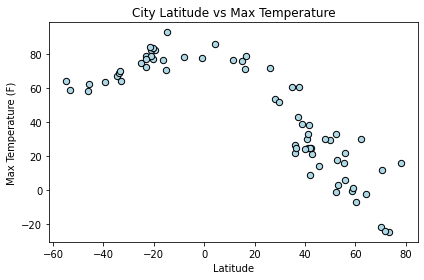

In [75]:
# lat_v_temp.plot(kind="scatter", x=lat, y=temp, grid=True, figsize=(9,9),
#               title="City Latitude Vs Max Temperature ", marker='o')
plt.scatter(lat, temp, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title ('City Latitude vs Max Temperature')
plt.tight_layout()
plt.show()

## Latitude vs. Humidity Plot

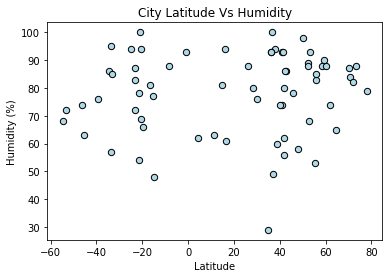

In [76]:
plt.scatter(lat, hum, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title('City Latitude Vs Humidity')
plt.tight_layout
plt.show()

## Latitude vs. Cloudiness Plot

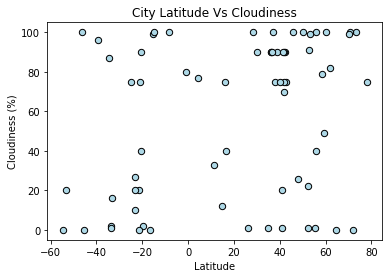

In [77]:
plt.scatter(lat, clo, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title('City Latitude Vs Cloudiness')
plt.tight_layout
plt.show()

## Latitude vs. Wind Speed Plot

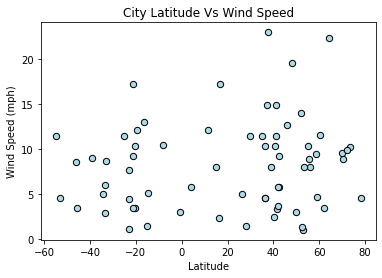

In [78]:
plt.scatter(lat, wds, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title('City Latitude Vs Wind Speed')
plt.tight_layout
plt.show()

## Linear Regression

In [79]:
north_hem = clean_city_data.loc[clean_city_data['Latitude'] > 0]
south_hem = clean_city_data.loc[clean_city_data['Latitude'] < 0]
south_hem

,City Name,Latitude,Longitude,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
3,isangel,-19.5417,169.28,82.54,66,2,12.15,VU,1612932783
4,okato,-39.1911,173.88,64,76,96,8.99,NZ,1612932783
6,vila velha,-20.3478,-40.295,77,94,90,3.44,BR,1612932783
7,hermanus,-34.4092,19.2504,66.99,86,87,5.01,ZA,1612932783
9,busselton,-33.6532,115.345,69.01,57,2,5.99,AU,1612932783
10,taolanaro,-25.0225,46.9854,75.2,94,75,11.5,MG,1612932784
12,avarua,-21.2129,-159.782,82.4,78,20,3.44,CK,1612932784
14,punta arenas,-53.1638,-70.9171,59,72,20,4.61,CL,1612932784
16,namibe,-15.1978,12.1576,70.97,77,99,1.5,AO,1612932784
19,arraial do cabo,-22.9673,-42.0268,72.27,87,10,4.43,BR,1612932785


In [80]:
nor_lat =north_hem['Latitude'].astype('float64')
nor_long = north_hem['Longitude'].astype('float64')
nor_temp = north_hem['Max Temp'].astype('float64')
nor_hum = north_hem['Humidity'].astype('float64')
nor_clo = north_hem['Cloudiness'].astype('float64')
nor_wds = north_hem['Wind Speed'].astype('float64')
nor_lat

0     58.607673
1     62.071293
2     14.997464
5     73.507735
8     16.736993
11    28.262375
13    55.839120
15     4.143695
17    37.284445
18    26.141621
20    41.054717
21    78.064847
22    42.652579
23    37.821037
24    60.374368
25    38.907609
30    40.890051
34    55.342222
36    42.453864
37    70.485569
38    11.283333
39    41.913717
40    50.076376
41    45.764056
44    52.877280
45    47.979522
46    70.070114
47    16.252559
48    52.455806
49    41.725891
50    36.241183
51    55.776079
54    52.140939
55    71.954308
56    36.148614
57    36.520898
59    53.191612
60    64.403164
61    59.117841
62    41.984073
63    40.148340
67    29.884944
68    41.283470
69    34.895796
Name: Latitude, dtype: float64

In [81]:
so_lat = south_hem['Latitude'].astype('float64')
so_long = south_hem['Longitude'].astype('float64')
so_temp = south_hem['Max Temp'].astype('float64')
so_hum = south_hem['Humidity'].astype('float64')
so_clo = south_hem['Cloudiness'].astype('float64')
so_wds = south_hem['Wind Speed'].astype('float64')
so_lat

3    -19.541720
4    -39.191082
6    -20.347782
7    -34.409200
9    -33.653158
10   -25.022531
12   -21.212901
14   -53.163833
16   -15.197832
19   -22.967337
26   -45.571225
27   -54.801912
28    -0.743292
29   -23.122303
31   -33.150329
32   -14.732768
33   -21.193500
42   -20.343862
52   -16.500413
53   -46.193952
58    -8.166246
64   -22.971779
65   -33.586407
66   -21.358118
Name: Latitude, dtype: float64

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

 The R Value is:-0.8817935215041034


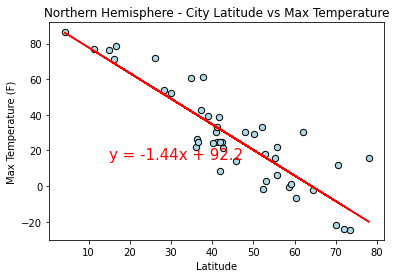

In [85]:
slope, intercept, rvalue, pvalue, stderr = linregress(nor_lat, nor_temp)
regress_values = nor_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nor_lat, nor_temp, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title ('Northern Hemisphere - City Latitude vs Max Temperature')
plt.plot(nor_lat,regress_values,"r-")
plt.annotate(line_eq,(15,15),fontsize=15,color="red")
print(f" The R Value is:{rvalue}")
plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

 The R Value is:0.7916259678133588


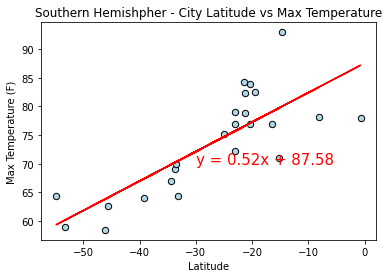

In [90]:
slope, intercept, rvalue, pvalue, stderr = linregress(so_lat, so_temp)
regress_values = so_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(so_lat, so_temp, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (F)')
plt.title ('Southern Hemishpher - City Latitude vs Max Temperature')
plt.plot(so_lat,regress_values,"r-")
plt.annotate(line_eq,(-30,70),fontsize=15,color="red")
print(f" The R Value is:{rvalue}")
plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

 The R Value is:0.1967267009549146


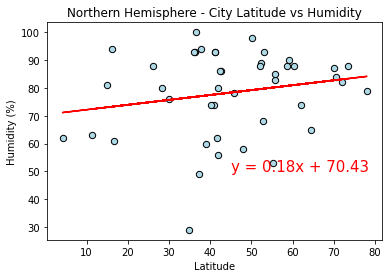

In [91]:
slope, intercept, rvalue, pvalue, stderr = linregress(nor_lat, nor_hum)
regress_values = nor_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nor_lat, nor_hum, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title ('Northern Hemisphere - City Latitude vs Humidity')
plt.plot(nor_lat,regress_values,"r-")
plt.annotate(line_eq,(45,50),fontsize=15,color="red")
print(f" The R Value is:{rvalue}")
plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

 The R Value is:0.2291348025460394


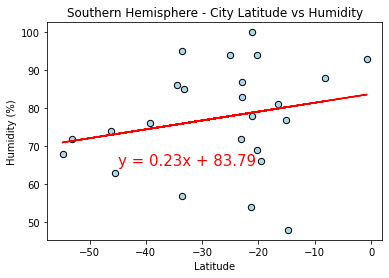

In [92]:
slope, intercept, rvalue, pvalue, stderr = linregress(so_lat, so_hum)
regress_values = so_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(so_lat, so_hum, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
plt.title ('Southern Hemisphere - City Latitude vs Humidity')
plt.plot(so_lat,regress_values,"r-")
plt.annotate(line_eq,(-45,65),fontsize=15,color="red")
print(f" The R Value is:{rvalue}")
plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

 The R Value is:0.09240637935595598


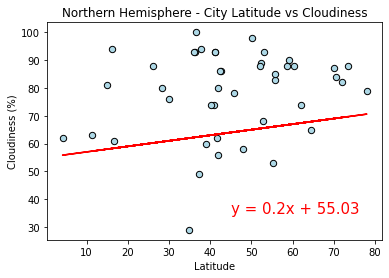

In [93]:
slope, intercept, rvalue, pvalue, stderr = linregress(nor_lat, nor_clo)
regress_values = nor_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nor_lat, nor_hum, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title ('Northern Hemisphere - City Latitude vs Cloudiness')
plt.plot(nor_lat,regress_values,"r-")
plt.annotate(line_eq,(45,35),fontsize=15,color="red")
print(f" The R Value is:{rvalue}")
plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

 The R Value is:0.2917060033092024


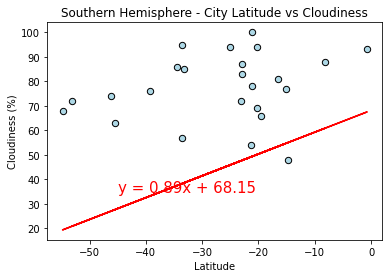

In [94]:
slope, intercept, rvalue, pvalue, stderr = linregress(so_lat, so_clo)
regress_values = so_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(so_lat, so_hum, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
plt.title ('Southern Hemisphere - City Latitude vs Cloudiness')
plt.plot(so_lat,regress_values,"r-")
plt.annotate(line_eq,(-45,35),fontsize=15,color="red")
print(f" The R Value is:{rvalue}")
plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

 The R Value is:0.027684320873968216


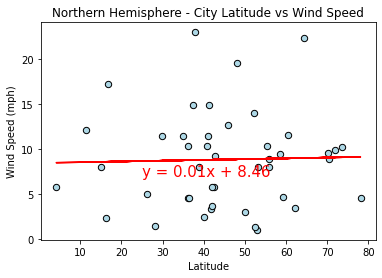

In [95]:
slope, intercept, rvalue, pvalue, stderr = linregress(nor_lat, nor_wds)
regress_values = nor_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(nor_lat, nor_wds, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title ('Northern Hemisphere - City Latitude vs Wind Speed')
plt.plot(nor_lat,regress_values,"r-")
plt.annotate(line_eq,(25,7),fontsize=15,color="red")
print(f" The R Value is:{rvalue}")
plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

 The R Value is:-0.00734036767426556


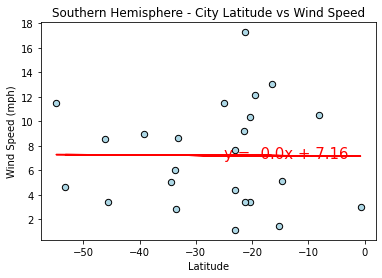

In [96]:
slope, intercept, rvalue, pvalue, stderr = linregress(so_lat, so_wds)
regress_values = so_lat * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(so_lat, so_wds, facecolors = 'lightblue', edgecolors = 'black', s = 40)
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
plt.title ('Southern Hemisphere - City Latitude vs Wind Speed')
plt.plot(so_lat,regress_values,"r-")
plt.annotate(line_eq,(-25,7),fontsize=15,color="red")
print(f" The R Value is:{rvalue}")
plt.show()